In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import poisson

# Jack's Car Rental

## Intro

In this section, we'll be reimplementing a solution to the Jack's Car Rental problem given in Example 4.2 of Chapter 4 of [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html) by Richard Sutton and Andrew Barto. In addition to implementing a solution to the original problem, we will also answer the associated exercise questions.

The initial problem setup is that Jack's Car Rental has two locations, each of which has a different demand for rentals and rate of rentals being returned to that location. After the businesses close each night, Jack can pay to shuttle cars from one location to another. The goal here is to find the optimal number of cars to shuttle between the two locations given the number of cars at each location at the end of the business day.

In particular, the number of rentals and returns per day at each location are Poisson distributed with a mean of 3 rentals and 3 returns at the first location, and 4 rentals and 2 returns at the second location. Jack makes \\$10 for each car he can rent on a given day (rental requests in excess of the number of cars available are unfulfilled and are missed sales), and pays \\$2 per car to shuttle overnight. Jack can also only move a maximum of 5 cars per night, and each location can hold at most 20 cars, any excess cars are imagined to be shuttled off to some other locations for the national chain.

To map this problem statement to the reinforcement learning terminology, the number of cars at each location the end of the day is the state, the actions are the number of cars to shuttle overnight, the reward is the net profit for the day, and the policy is then how many cars to shuttle given a particular number of cars at each location to maximize the profit.

Short tangent on why I found this exercise particularly enlightening:

I've mainly been watching [David Silver's lectures on reinforcement learning](https://www.davidsilver.uk/teaching/), and if you look through the [slides](https://www.davidsilver.uk/wp-content/uploads/2020/03/DP.pdf) for David Silver's lecture on dynamic programming, you'll see that he expresses the iterative step of policy evaluation as follows:

$v_{k+1}(s) = \sum_{a\in A} \pi(a|s) (R^{a}_{s} + \gamma\sum_{s' \in S} P^{a}_{ss'}v_{k}(s'))$

whereas this is the presentation in Sutton and Barto:

$V(s) = \sum_{s', r} p(s', r | s, \pi(s))[r + \gamma V(s')]$

I think it's worth comparing the two presentations since they both make different things clear:
 - Silver's presentation shows that policy can be stochastic, as shown by the $\pi(a|s)$ term in the expected reward calculation
 - Silver's presentation shows the reward as a constant given the action and state, whereas the Sutton presentation shows that the reward's value can be stochastic as well, and that the probability of a given reward needs to be folded into the expected reward calculation
 
Since I was primarily working off of David Silver's lecture, this second point was made more concrete for me by working through this exercise, as the rewards are stochastic since the number of rental requests are stochastic, and the same state transition can be made multiple ways but with different rewards (e.g. 1 rental request, 2 returns; 2 rental requests, 3 returns; etc.). I felt that working through this problem helped unify the nuances between the two presentations and give a more complete picture of the policy iteration approach.

## Math behind approach

In order to use policy iteration to solve this problem, we need to be able to write down the probability of transitioning from one state to another. Since the number of rentals and returns are a random variable, there are multiple numbers of rentals and returns that can result in the same state transition. For example, we could go from 15 cars to 12 cars as a result of 3 rentals and 0 returns, 4 rentals and 1 return, etc. Since each of these numbers of rentals/returns have a different probability (coming from their Poisson distributions), we want to sum the probability of all the combinations to get the total probabilty of a given state transition. Since these probabilities aren't changing over time, we can precompute them to speed up our policy iteration process.

In addition to precomputing the state transition probabilities over some grid of reasonable rental/return values, we can also precompute the expected reward coming from rentals alone, since this is only a function of the number of cars (i.e. the state) and the distribution of the number of rentals/returns (which we know). We can then add in the cost associated with our action when we actually perform the policy iteration process. 

To see this in actual math notation, we can look at the policy iteration update step:

$V(s) = \sum_{s', r} p(s', r | s, \pi(s))[r + \gamma V(s')]$

what we're doing here is explicitly splitting out the sum over states and reward values:

**(1)** $V(s) = \sum_{s'} \sum_{r} p(s', r | s, \pi(s))[r + \gamma V(s')]$

for convenience, we can next rewrite the probability of a given state transition and reward (i.e. a given number of rentals and returns from our current state):

**(2)** $ p(s', r | s, \pi(s)) = p_{ss'}^{r}$

and substitute **(2)** back into **(1)** and distribute:

**(3)** $V(s) = \sum_{s'} [\sum_{r} (p_{ss'}^{r}r) + \sum_{r} (p_{ss'}^{r} \gamma V(s'))]$

we can now look more closely at the two terms that are sums over the reward value.

First we see that the term $\gamma V(s')$ doesn't depend on the reward value at all, just the next state, and rewrite:

**(4)** $\sum_{r} (p_{ss'}^{r} \gamma V(s')) = \gamma V(s') \sum_{r} p_{ss'}^{r} = \gamma V(s') p_{ss'}$

where $p_{ss'}$ is the total probability of transitioning from state $s$ to state $s'$ summed over all (probable) numbers of rentals and returns that could give that transition.

Next we can note that the second term is just the expected reward given that we're transitioning from $s$ to $s'$:

**(5)** $\sum_{r} p_{ss'}^{r}r = \mathbb{E}_{ss'}[r]$

Substituting **(4)** and **(5)** back into **(3)**:


**(6)** $V(s) = \sum_{s'} \mathbb{E}_{ss'}[r] + p_{ss'}^{r} \gamma V(s')$

where we can now see that the only term here that changes across iterations is the value function itself, hence we can precompute $\mathbb{E}_{ss'}[r]$ and $p_{ss'}^{r}$ and save ourselves a ton of computation during the actual policy evaluation portion of the algorithm.

Note that this approach is possible here because:
 - transition probabilities and rewards are constant over time
 - transition probabilities are unaffected by our action (given that we call state $s$ as the state we end up in after taking the action of moving cars)




These transition probabilities and expected rewards will be stored in a 4D array, where the first and second dimensions are the current state and the third and fourth dimensions are the future state: [curr_cars_loc1, curr_cars_loc2, next_cars_loc1, next_cars_loc2]

## Initial solution

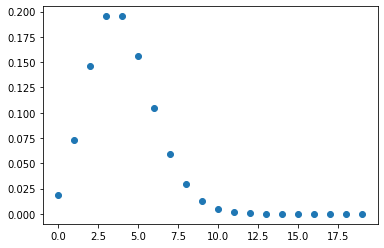

In [2]:
# Since we have Poisson random variables here, which theoretically could
# lead to an infinite number of cars being rented or returned, we want to
# understand what's a reasonable number of rentals or returns with
# non-trivial probability to use as a maximum for our calculations.
# Based on the plot below, 14 seems reasonable.
x = np.arange(0, 20)
y = poisson.pmf(x, 4)
plt.scatter(x, y)

In [3]:
# Maximum number of cars per location.
max_cars = 20
# Actual dimension of state matrix (since we can also have 0 cars).
d = max_cars+1
# Maximum number of cars we can move per night.
max_move = 5
# Maximum value of number of rentals and returns to consider.
max_poisson = 14

# Mean number of rentals and returns per location.
loc1_rent_mean = 3
loc1_return_mean = 3
loc2_rent_mean = 4
loc2_return_mean = 2

# Reward for rentals.
rent_reward = 10
# Cost for moving a car overnight.
move_cost = -2
# Discount factor.
gamma = 0.9

In [4]:
# Precompute Poisson PMF out to the maximum amount.
def populatePoisLookup(mean, max_val=max_poisson):
    return poisson(mean).pmf(np.arange(max_val+1))

loc1_rent_dist = populatePoisLookup(loc1_rent_mean)
loc1_return_dist = populatePoisLookup(loc1_return_mean)
loc2_rent_dist = populatePoisLookup(loc2_rent_mean)
loc2_return_dist = populatePoisLookup(loc2_return_mean)

In [52]:
# Calculate transition probabilities and expected rewards for each
# possible state given a current state.
def calculate_one_state(curr_loc1, curr_loc2):
    expected_reward = np.zeros((d, d))
    transition_prob = np.zeros((d, d))
    
    # Iterate over number of rentals and returns at each location,
    # capping the number of rentals to be at most the number of cars
    # at the location, and capping the final number of cars after returns
    # to be at most `max_cars`.
    for rent1 in range(max_poisson):
        for rent2 in range(max_poisson):
            # Probabilities of number of rental requests at each location.
            p_rent1 = loc1_rent_dist[rent1]
            p_rent2 = loc2_rent_dist[rent2]

            # Number of cars actually rented (i.e. at most the number
            # of available cars). Note that cars become available for
            # rent the next day, so we don't include the number of returns
            # in the number of cars available for rent.
            actual_rent1 = min(rent1, curr_loc1)
            actual_rent2 = min(rent2, curr_loc2)
            
            for return1 in range(max_poisson):
                for return2 in range(max_poisson):
                    # Probabilities of number of returns.
                    p_return1 = loc1_return_dist[return1]
                    p_return2 = loc2_return_dist[return2]
                    
                    # What's the state we end up in after this number of 
                    # rentals and returns, capped at being at most the
                    # maximum number of cars per location.
                    future_loc1 = min(curr_loc1 + return1 - actual_rent1, max_cars)
                    future_loc2 = min(curr_loc2 + return2 - actual_rent2, max_cars)

                    # Total probability of this number of rental requests
                    # and returns at both locations.
                    total_p = p_rent1*p_rent2*p_return1*p_return2
                    # Actual reward from rentals.
                    reward = (actual_rent1 + actual_rent2)*rent_reward

                    # Add the transition probability and probability-weighted
                    # reward for the future state for this specific combination
                    # of rentals and returns.
                    transition_prob[future_loc1, future_loc2] += total_p
                    expected_reward[future_loc1, future_loc2] += total_p*reward
            
    return transition_prob, expected_reward

# Calculate transition probabilities and expected rewards for every combination 
# of current state and future state.
def calculate_probs_and_rewards():
    transition_prob = np.zeros((d, d, d, d))
    expected_reward = np.zeros((d, d, d, d))
    
    for curr_loc1, curr_loc2 in np.ndindex((d, d)):
        p, r = calculate_one_state(curr_loc1, curr_loc2)
        
        # Since `p` represents the probability of transitioning to any other
        # possible state from (curr1, curr2), good to sanity check that total
        # probability is close to 1 despite our simplification of only considering
        # at most 14 rentals/returns.
        assert(1 - p.sum() < 1e-4)
        
        transition_prob[curr_loc1, curr_loc2] = p       
        expected_reward[curr_loc1, curr_loc2] = r
        
    return transition_prob, expected_reward

In [53]:
# Actual policy iteration code. As in Sutton, we implement the policy
# as a matrix of values where the value indicates the number of cars
# to move from location 1 to location 2 and a negative value indicates
# instead moving cars from location 2 to location 1.

# Calculate the state value function for a single state given
# our current action at this state.
def backup_one(value_fn,
               num_move,
               curr_loc1,
               curr_loc2,
               transition_probs,
               expected_rewards,
               exercise_47=False):
    curr1_after_move = min(curr_loc1 - num_move, max_cars)
    curr2_after_move = min(curr_loc2 + num_move, max_cars)
    
    val = 0
    for future_loc1, future_loc2 in np.ndindex(value_fn.shape):
        p = transition_probs[curr1_after_move, curr2_after_move,
                             future_loc1, future_loc2]
        r = expected_rewards[curr1_after_move, curr2_after_move,
                             future_loc1, future_loc2]

        
        # Note that the expected reward is already weighted by the
        # appropriate probabilities of rentals/returns, so it's excluded
        # from being multiplied by the state transition probability here.
        this_reward = r + p * gamma * value_fn[future_loc1, future_loc2]
        val += this_reward
        
    move_penalty = np.abs(num_move)*move_cost
    
    # Modifications for exercise 4.7.
    if exercise_47:
        # Want to allow one car to move for free if cars are being moved
        # from the first location to second location
        if num_move >= 1:
            move_penalty -= move_cost
            
        # If a location has more than 10 cars at the end of the night
        # (i.e. after moving cars), then we incur a $4 penalty.
        if curr1_after_move > 10:
            val -= 4
        if curr2_after_move > 10:
            val -= 4

    # Add in cost from moving cars.
    return val + move_penalty

# Run one round of in-place policy evaluation until convergence.
def evaluate(value_fn,
             policy,
             transition_probs,
             expected_rewards,
             exercise_47=False):
    # Store state-value function before policy evaluation so we
    # can see if current policy is equivalent to previous one by
    # checking the delta for all states. Note that this also answers
    # exercise 4.4 (see below for explanation).
    prev_value_fn = np.copy(value_fn)
    
    # Iterate value function evaluation until delta is sufficiently small.
    while True:
        iter_delta = 0
        for curr_loc1, curr_loc2 in np.ndindex(value_fn.shape):
            new_val = backup_one(value_fn,
                                 policy[curr_loc1, curr_loc2],
                                 curr_loc1,
                                 curr_loc2,
                                 transition_probs,
                                 expected_rewards,
                                 exercise_47=exercise_47)
            iter_delta = max(np.abs(new_val - value_fn[curr_loc1, curr_loc2]),
                        iter_delta)

            value_fn[curr_loc1, curr_loc2] = new_val
       # break
        if iter_delta <= 1e-4:
            break
            
    # Check if new policy is equivalent to previous.
    return np.all(np.isclose(prev_value_fn, value_fn))

# Run one round of policy improvement using greedy best move.
def iterate(value_fn,
            policy,
            transition_probs,
            expected_rewards,
            exercise_47=False):
    # Identify greedy best move for each state. Also check if the policy
    # is stable.
    is_stable = True
    for curr_loc1, curr_loc2 in np.ndindex(value_fn.shape):
        best_move = 0
        best_val = 0
        for num_move in np.arange(-max_move, max_move+1):
            # Ignore moves that exceed the number of available cars.
            if num_move > curr_loc1 or -num_move > curr_loc2:
                continue
            
            # Expected reward for taking this action from this state.
            check_val = backup_one(value_fn,
                                   num_move,
                                   curr_loc1,
                                   curr_loc2,
                                   transition_probs,
                                   expected_rewards,
                                   exercise_47=exercise_47)
            
            if check_val > best_val:
                best_val = check_val
                best_move = num_move
                
        if best_move != policy[curr_loc1, curr_loc2]:
            is_stable = False
        policy[curr_loc1, curr_loc2] = best_move
    return is_stable

def policy_iteration(exercise_47=False):
    # Precalculate state transition probabilities and expected
    # rewards for each state transition.
    p, r = calculate_probs_and_rewards()
    
    # Begin policy iteration
    value_fn = np.zeros((d, d))
    policy = np.zeros((d, d), dtype=int)
    
    i = 0
    while True:
        is_equiv = evaluate(value_fn,
                            policy, 
                            p,
                            r,
                            exercise_47=exercise_47)
        stable_policy = iterate(value_fn,
                                policy,
                                p,
                                r,
                                exercise_47=exercise_47)
        print(f"iter {i}: is_equiv={is_equiv}, stable={stable_policy}")
        i += 1
        if stable_policy or is_equiv:
            break
    return value_fn, policy

In [ ]:
ax.set_x

In [68]:
def plot_heatmap(data, **kwargs):
    ax = sns.heatmap(data, **kwargs)
    ax.invert_yaxis()
    ax.set_xlabel("Number of cars at second location")
    ax.set_ylabel("Number of cars at first location")

In [54]:
optimal_v, optimal_p = policy_iteration()

iter 0: is_equiv=False, stable=False
iter 1: is_equiv=False, stable=False
iter 2: is_equiv=False, stable=False
iter 3: is_equiv=False, stable=False
iter 4: is_equiv=False, stable=False
iter 5: is_equiv=True, stable=True


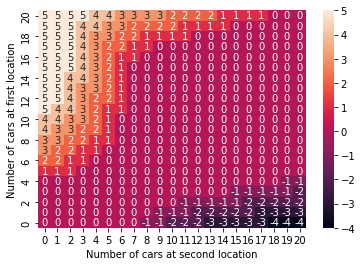

In [69]:
plot_heatmap(optimal_p, annot=True)

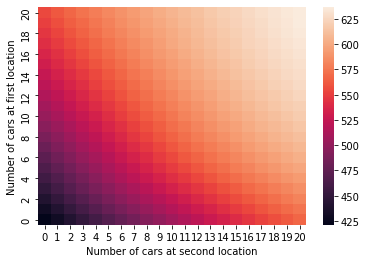

In [70]:
plot_heatmap(optimal_v)

While our exact optimal policy seems as if it differs from that shown in figure 4.2 of the textbook (somewhat hard to tell since we have to guess based off rectangle widths), the overall shape of the policy contours look correct and the final state-value function has the same shape and scale.

## Exercise 4.4

Note our modification in the policy evaluation step: check if the optimal state-value function for this policy is equal (within some epsilon) to the previous one at all states. By the policy improvement theorem, we know that our state-value function will be strictly increasing throughout the policy iteration process, so if we reach two policies that have equal state-value functions, then we know that both policies are optimal (can also see pg 79 of the textbook for more details).

## Exercise 4.5

## Exercise 4.7

One of Jack’s employees at the first location
rides a bus home each night and lives near the second location. She is happy to shuttle
one car to the second location for free. Each additional car still costs $2, as do all cars
moved in the other direction. In addition, Jack has limited parking space at each location.
If more than 10 cars are kept overnight at a location (after any moving of cars), then an
additional cost of \\$4 must be incurred to use a second parking lot (independent of how
many cars are kept there). 

In [57]:
optimal_v_47, optimal_p_47 = policy_iteration(exercise_47=True)

iter 0: is_equiv=False, stable=False
iter 1: is_equiv=False, stable=False
iter 2: is_equiv=False, stable=False
iter 3: is_equiv=False, stable=False
iter 4: is_equiv=False, stable=True


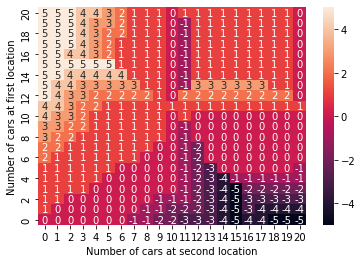

In [71]:
plot_heatmap(optimal_p_47, annot=True)

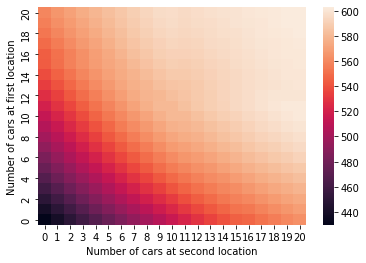

In [72]:
plot_heatmap(optimal_v_47)

Not totally sure if the above results are correct, but we do see some changes in the policy that are consistent with what we might expect:
 - Looking at verticals and horizontals near 10, we see that the policy is to move cars between locations to try to keep the other location at exactly 10 cars at the end of the night, consistent with the extra cost of having  greater than 10 cars at a location overnight
 - Much more aggressive at moving a single car to the second location since it's free
 - When both locations are at 11 cars, favors moving one to the second location to take the penalty there, again because moving a single car to the second location is free
 
Another interesting thing to me is that the state-value function is still relatively smooth, i.e. no large jumps around 10 for either location. This could either be a bug in my code, or it could be that since the policy is generally trying to avoid the penalty for having more than 10 cars at a location, we still see a relatively smooth state-value function.

# Gambler's Problem

In this section we write a solution to the problem given in Example 4.2, in which a gambler plays a game where they place a wager on a biased coin flip. If the coin comes up heads, they double their wager, if it comes up tails, then they lose their wager. The problem to solve here is to calculate the optimal policy given that the gambler gets a reward of 1 if they can accumulate \\$100, and 0 reward otherwise. The two terminal states are thus 0 and 100.

We solve this problem via value iteration.

## Initial solution

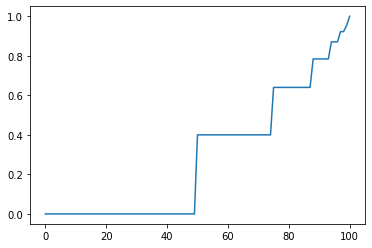

In [70]:
plt.plot(np.arange(end_val+1), value_fn)

In [98]:
# Precision for value iteration.
eps = 1e-9

# Perform the full value iteration algorithm.
def value_iterate(end_val=100,
                  p_heads=0.4):
    value_fn = np.zeros(end_val+1)
    value_fn[end_val] = 1
    
    i = 0
    while True:
        delta = single_iterate(value_fn,
                               end_val=end_val, 
                               p_heads=p_heads)
        print(f"iter {i}: {delta:0.4f}")
        
        if delta < eps:
            break
        i += 1
    return value_fn


# Perform single iteration of the value iteration algorithm.
def single_iterate(value_fn, end_val=100, p_heads=0.4):
    max_delta = 0
    for state in np.arange(end_val):
        
        possible_wagers = np.arange(0, min(state, end_val-state)+1)
        
        max_val = 0
        for w in possible_wagers:
            max_val = max(calc_wager_value(value_fn, state, w, p_heads), max_val)
                
        max_delta = max(np.abs(max_val - value_fn[state]), max_delta)
            
        value_fn[state] = max_val
    return max_delta

# Calculate the state-action value for a single wager given the current state.
# Note that the main reason for splitting this out is for the exploration
# that we'll do later.
def calc_wager_value(value_fn, state, wager, p_heads=0.4):
    win_state = state + wager
    lose_state = state - wager

    return p_tails*value_fn[lose_state] + p_heads*value_fn[win_state]


# Generate an optimal policy from the optimal state-value function.
def policy_from_value(value_fn):
    policy = np.zeros(end_val)
    for state in np.arange(end_val):
        best_val = 0
        best_wager = 0
        # Note that we exclude the action of making no wager, since 
        # this by definition will be tied for any other optimal action,
        # but isn't actually a useful action.
        for wager in  np.arange(1, min(state, end_val-state)+1):
            wager_val = calc_wager_value(value_fn, state, wager)
            if (wager_val - best_val) > eps:
                best_val = wager_val
                best_wager = wager
        policy[state] = best_wager
    return policy

In [99]:
final_v = value_iterate()

iter 0: 0.9533
iter 1: 0.3689
iter 2: 0.1393
iter 3: 0.0557
iter 4: 0.0223
iter 5: 0.0089
iter 6: 0.0016
iter 7: 0.0004
iter 8: 0.0001
iter 9: 0.0000
iter 10: 0.0000
iter 11: 0.0000
iter 12: 0.0000
iter 13: 0.0000
iter 14: 0.0000
iter 15: 0.0000
iter 16: 0.0000


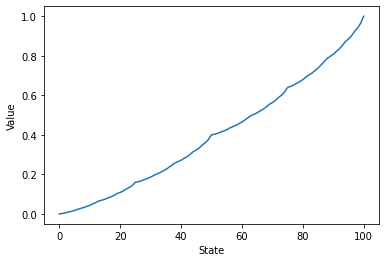

In [108]:
plt.plot(np.arange(101), final_v)
plt.xlabel("State")
_ = plt.ylabel("Value")

In [101]:
policy = policy_from_value(final_v)

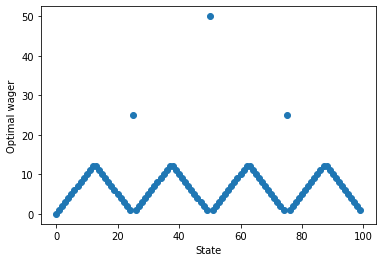

In [102]:
plt.scatter(np.arange(100), policy)
plt.xlabel("State")
_ = plt.ylabel("Optimal wager")

### Thoughts

An interesting thing to observe is the jumps in the state-value function at 25, 50, and 75. Intuitively, this somewhat makes sense, since those are the values at which the integer number of bets we have to win to reach 100 changes in a "significant" way. By zooming in on the state-value function, we can actually also see a similar jump at 13 as well.

For example at states < 25, we need at least 3 wins in a row to reach 100, but at states 25 <= s < 50 we can reach 100 in 2 wins in a row, etc.

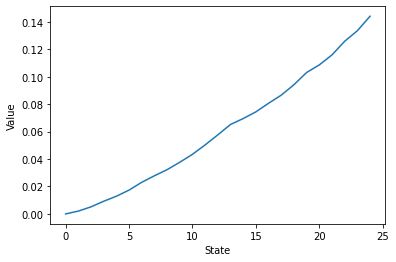

In [103]:
plt.plot(np.arange(25), final_v[:25])
plt.xlabel("State")
_ = plt.ylabel("Value")

This jump in the state value function at states that indicate a different number of wins required to reach the end value also so plays out if we change the end value:

In [104]:
final_v_120 = value_iterate(end_val=120)

iter 0: 0.9533
iter 1: 0.3689
iter 2: 0.1393
iter 3: 0.0502
iter 4: 0.0201
iter 5: 0.0066
iter 6: 0.0016
iter 7: 0.0003
iter 8: 0.0001
iter 9: 0.0000
iter 10: 0.0000
iter 11: 0.0000
iter 12: 0.0000
iter 13: 0.0000
iter 14: 0.0000
iter 15: 0.0000
iter 16: 0.0000
iter 17: 0.0000
iter 18: 0.0000
iter 19: 0.0000


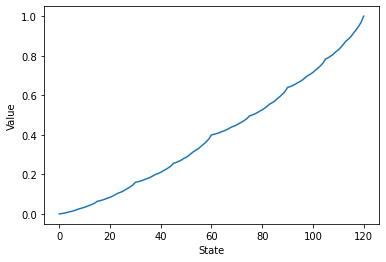

In [106]:
plt.plot(np.arange(121), final_v_120)
plt.xlabel("State")
_ = plt.ylabel("Value")

The textbook also asks "there is a whole family of optimal policies, all corresponding to ties for the argmax action selection with respect to the optimal value function. Can you guess what the entire family looks like?"

It seems like there's one trivial family of optimal policies and one interesting one. The trivial family is just any policies where the action at a given state is to bet nothing, since that's technically an allowed action in the problem setup. Since the definition of the state-value function is the maximum return we can achieve from this state if we behave optimally, then the action that always leads us back to our current state (i.e. wagering zero) will always be tied with the optimal action that takes us to a different state.

The interesting family of optimal policies is that for each state greater than 13, there's actually a tie for the optimal action, where the alternative action is to just wager everything if the state is less than 50 or wager enough to immediately win if the state is greater than 50. We can see this with the following modified code for calculating a policy from the optimal state-value function:

In [84]:
def policy_from_value_reversed(value_fn):
    policy = np.zeros(end_val)
    for state in np.arange(end_val):
        best_val = 0
        best_wager = 0
        # The only difference here is that we reverse the order in
        # which we consider the possible actions, leading to the
        # larger value being selected in the case of a tie.
        for wager in reversed(np.arange(1, min(state, end_val-state)+1)):
            wager_val = calc_wager_value(value_fn, state, wager)
            if (wager_val - best_val) > eps:
                best_val = wager_val
                best_wager = wager
        policy[state] = best_wager
    return policy

In [85]:
other_policy = policy_from_value_reversed(final_v)

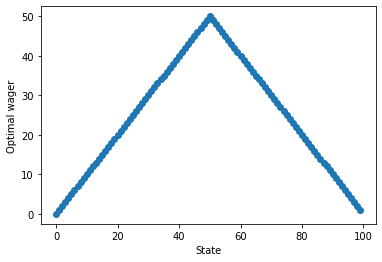

In [89]:
plt.scatter(np.arange(end_val), other_policy)
plt.xlabel("State")
_ = plt.ylabel("Optimal wager")

So we can see that the interesting shaped policy presented initially is a valid optimal policy, albeit slightly less intuitive than the one that just attempts to win as fast possible.

## Exercise 4.8

The above demonstration of alternate optimal policies is useful context for answering this question. We can see that if we currently have \\$51, then betting \\$1 or \\$49 are both optimal actions. We can also see that by plotting the action-value function for each possible wager given that we currently have \\$51:

In [123]:
def plot_action_value(value_fn, state):
    max_check = min(state, 100-state+1)
    x = np.arange(0, max_check)
    y = [calc_wager_value(value_fn, state, i) for i in x]
    plt.scatter(x, y)

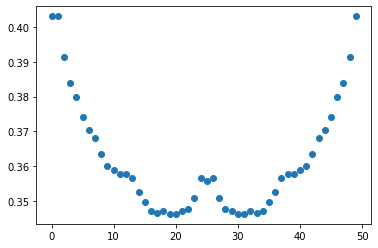

In [124]:
plot_action_value(final_v, 51)

There's also a very interesting symmetry around 25, i.e. that betting 1 is just as good as betting 49, or betting 2 is just as good as betting 48, and so on. While I don't have a mathematical proof for this, we can see that this plays out for other states as well as other jumps in the state value function

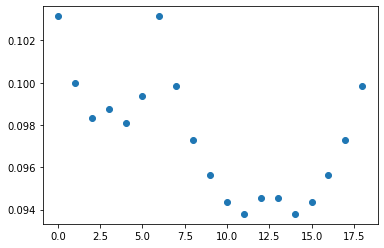

In [125]:
plot_action_value(final_v, 19)